In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence, Optional, Tuple, Literal
from sentence_transformers import SentenceTransformer
from lime.lime_text import LimeTextExplainer
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#functions
def plot_confusion_heatmap(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_names: Sequence[str],
    title: str = "Confusion Matrix",
    normalize: Optional[Literal["true", "pred", "all"]] = None,
    figsize: Tuple[int, int] = (12, 8),
    cmap: str = "Blues",
    annot: bool = True,
    fmt: Optional[str] = None,
) -> None:
    """
    Plots a confusion matrix heatmap for multi-class classification.

    Args:
    - y_true (np.ndarray): Ground-truth labels (encoded as integers).
    - y_pred (np.ndarray): Predicted labels (encoded as integers).
    - class_names (Sequence[str]): Class names in encoder order (e.g., label_encoder.classes_).
    - title (str): Title of the plot.
    - normalize (Optional[Literal['true','pred','all']]): Normalization mode per sklearn.confusion_matrix.
    - figsize (Tuple[int, int]): Figure size in inches (width, height).
    - cmap (str): Matplotlib colormap name.
    - annot (bool): Whether to annotate cell values.
    - fmt (Optional[str]): Annotation format; defaults to 'd' if unnormalized else '.2f'.

    Returns:
    - None
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    if fmt is None:
        fmt = ".2f" if normalize else "d"

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=annot,
        fmt=fmt,
        xticklabels=class_names,
        yticklabels=class_names,
        cmap=cmap,
        cbar_kws={"label": "Proportion" if normalize else "Count"},
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [3]:
#load models and components
log_reg_model = joblib.load("../models/logreg.joblib")
svm_model = joblib.load("../models/svm.joblib")
rf_model = joblib.load("../models/rfc.joblib")
xgb_model = joblib.load("../models/xgb.joblib")
tfidf_vectorizer = joblib.load("../models/tfidf.joblib")
label_encoder = joblib.load("../models/label_encoder.joblib")
scaler = joblib.load("../models/scaler.joblib")

#load validation data and embeddings
val_data = pd.read_csv("../data/processed/val_tickets.csv")
val_embeddings = np.load("../data/processed/X_val_sbert.npy")

#load test data and embeddings
test_data = pd.read_csv("../data/processed/test_tickets.csv")
test_embeddings = np.load("../data/processed/X_test_sbert.npy")

#### Logisitic Regression

Logistic Regression Macro F1: 0.6216
Logistic Regression Weighted F1: 0.6356


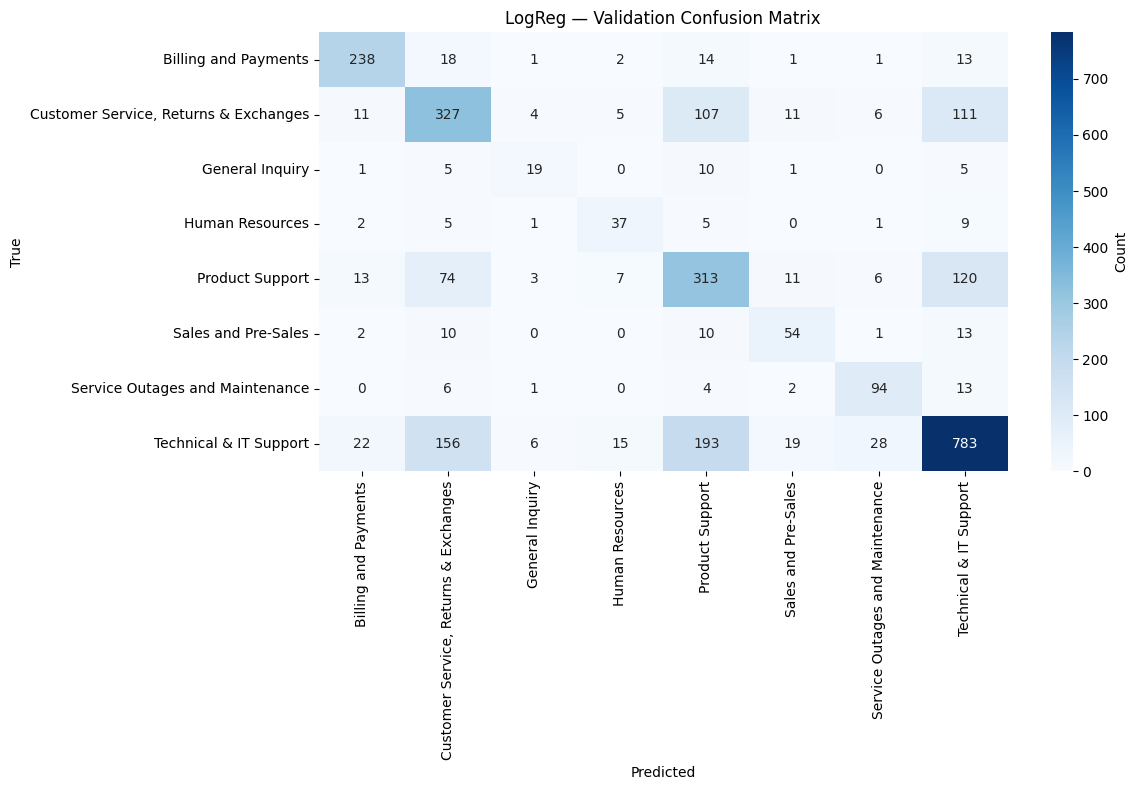

In [4]:
# declare log_reg_X and log_reg_y for logistic regression
log_reg_raw_y = val_data["queue_grouped"].astype(str)
log_reg_raw_X = val_data["redacted_text_clean"]

#encode labels
log_reg_enc_y = label_encoder.transform(log_reg_raw_y)

#vectorize text
log_reg_vec_x = tfidf_vectorizer.transform(log_reg_raw_X)

#make predictions
log_reg_preds = log_reg_model.predict(log_reg_vec_x)

#evaluate model
lr_macro_f1    = f1_score(log_reg_enc_y, log_reg_preds, average="macro")
lr_weighted_f1 = f1_score(log_reg_enc_y, log_reg_preds, average="weighted")

# save results for visualization
results_rows = []
results_rows.append({
    "model": "Logistic Regression",
    "representation": "TF-IDF",
    "macro_f1": lr_macro_f1,
    "weighted_f1": lr_weighted_f1,
})

#print f1 scores and plot confusion matrix
print(f"Logistic Regression Macro F1: {lr_macro_f1:.4f}")
print(f"Logistic Regression Weighted F1: {lr_weighted_f1:.4f}")
plot_confusion_heatmap(
    y_true=log_reg_enc_y,
    y_pred=log_reg_preds,
    class_names=label_encoder.classes_,
    title="LogReg — Validation Confusion Matrix",
)

#### XGBoost

XGBoost Macro F1: 0.6286
XGBoost Weighted F1: 0.6622


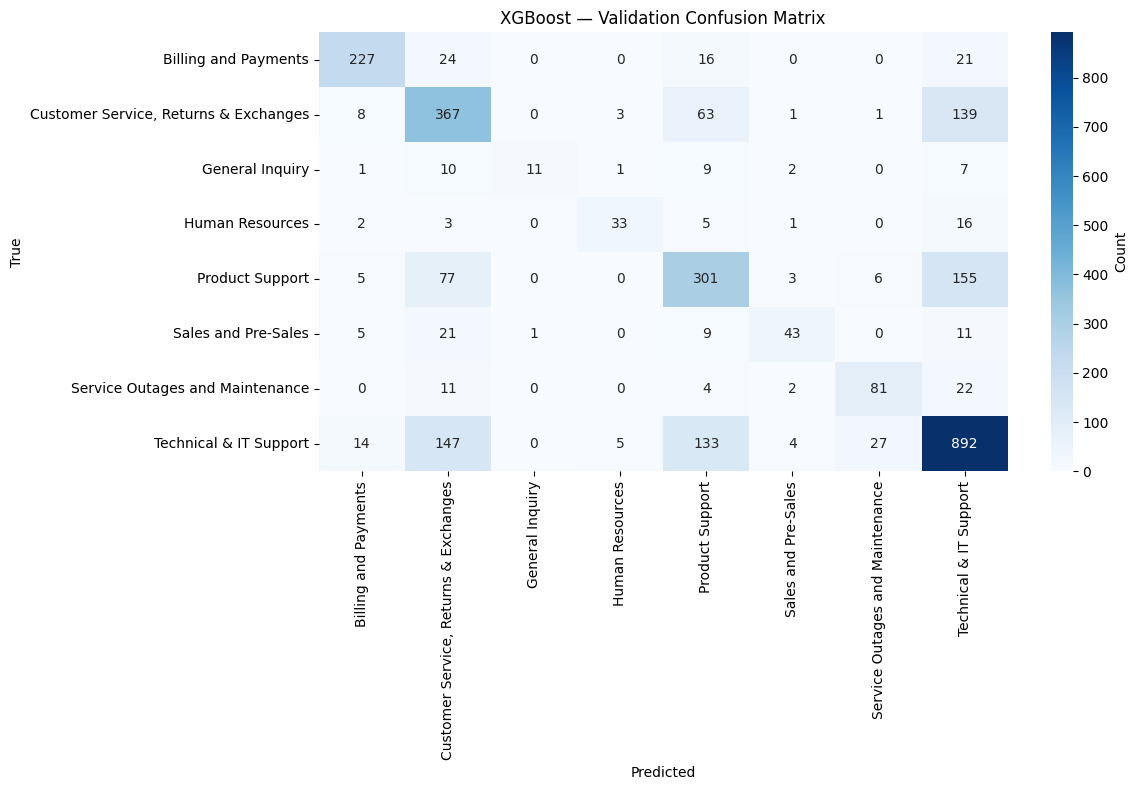

In [5]:
# declare xgb_X and xgb_y for XGBoost
xgb_raw_y = val_data["queue_grouped"].astype(str)
xgb_enc_y = label_encoder.transform(xgb_raw_y)

# use Sentence Transformer embeddings as features
xgb_X = val_embeddings

# make predictions
xgb_preds = xgb_model.predict(xgb_X)

# evaluate model
xgb_macro_f1 = f1_score(xgb_enc_y, xgb_preds, average="macro")
xgb_weighted_f1 = f1_score(xgb_enc_y, xgb_preds, average="weighted")

# save results 
results_rows.append({
    "model": "XGBoost",
    "representation": "Embeddings",
    "macro_f1": xgb_macro_f1,
    "weighted_f1": xgb_weighted_f1,
})

# print f1 scores and plot confusion matrix
print(f"XGBoost Macro F1: {xgb_macro_f1:.4f}")
print(f"XGBoost Weighted F1: {xgb_weighted_f1:.4f}")

plot_confusion_heatmap(
    y_true=xgb_enc_y,
    y_pred=xgb_preds,
    class_names=label_encoder.classes_,
    title="XGBoost — Validation Confusion Matrix",
)

#### Random Forest Classifier

Random Forest Macro F1: 0.6319
Random Forest Weighted F1: 0.6973


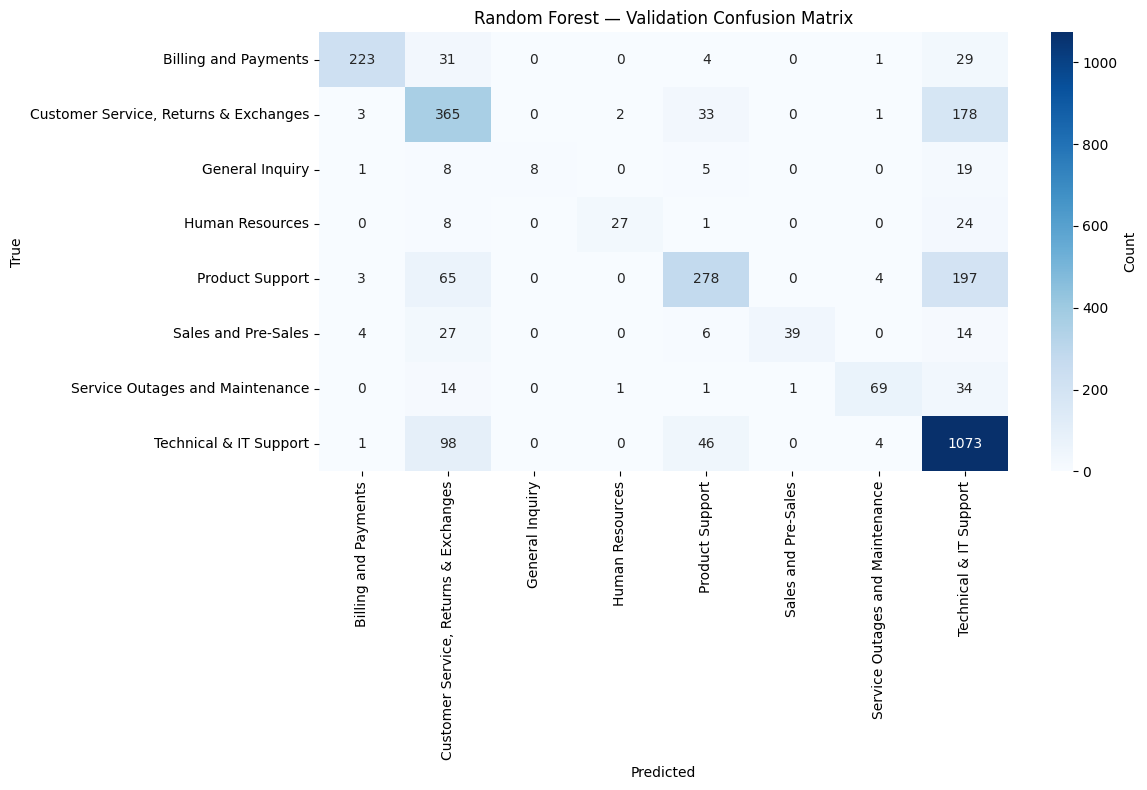

In [6]:
# declare rfc_X and rfc_y for Random Forest
rfc_raw_y = val_data["queue_grouped"].astype(str)
rfc_enc_y = label_encoder.transform(rfc_raw_y)

# use Sentence Transformer embeddings as features
rfc_X = val_embeddings

# make predictions
rfc_preds = rf_model.predict(rfc_X)

# evaluate model
rf_macro_f1    = f1_score(rfc_enc_y, rfc_preds, average="macro")
rf_weighted_f1 = f1_score(rfc_enc_y, rfc_preds, average="weighted")

# save results for visualization 
results_rows.append({
    "model": "Random Forest",
    "representation": "Embeddings",
    "macro_f1": rf_macro_f1,
    "weighted_f1": rf_weighted_f1,
})

# print f1 scores and plot confusion matrix
print(f"Random Forest Macro F1: {rf_macro_f1:.4f}")
print(f"Random Forest Weighted F1: {rf_weighted_f1:.4f}")

plot_confusion_heatmap(
    y_true=rfc_enc_y,
    y_pred=rfc_preds,
    class_names=label_encoder.classes_,
    title="Random Forest — Validation Confusion Matrix",
)

#### Support Vector Classification

SVC Macro F1: 0.7458
SVC Weighted F1: 0.7891


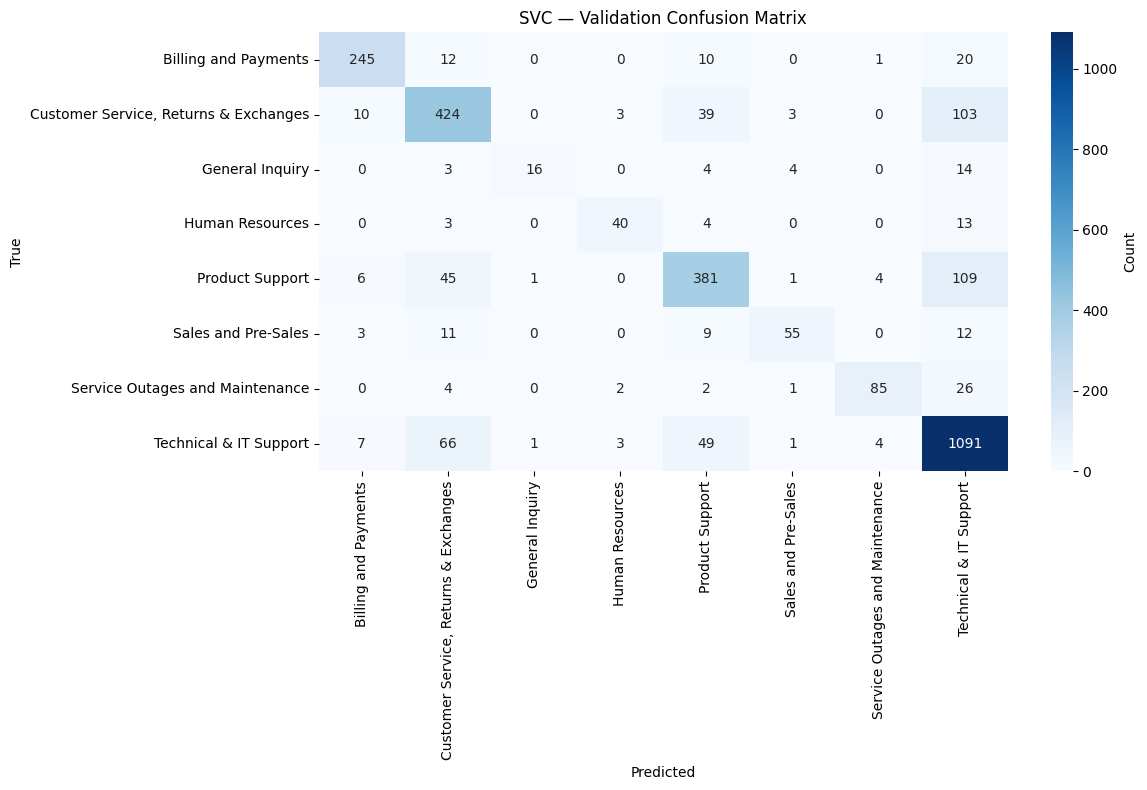

In [7]:
# declare svc_X and svc_y for Support Vector Classifier
svc_raw_y = val_data["queue_grouped"]
svc_enc_y = label_encoder.transform(svc_raw_y)

# use Sentence Transformer embeddings as features, then scale
svc_X = val_embeddings
svc_X_scaled = scaler.transform(svc_X)

# make predictions
svc_preds = svm_model.predict(svc_X_scaled)

# evaluate model
svc_macro_f1    = f1_score(svc_enc_y, svc_preds, average="macro")
svc_weighted_f1 = f1_score(svc_enc_y, svc_preds, average="weighted")

# save results for visualization
results_rows.append({
    "model": "SVC",
    "representation": "Embeddings",
    "macro_f1": svc_macro_f1,
    "weighted_f1": svc_weighted_f1,
})

# print f1 scores and plot confusion matrix
print(f"SVC Macro F1: {svc_macro_f1:.4f}")
print(f"SVC Weighted F1: {svc_weighted_f1:.4f}")

plot_confusion_heatmap(
    y_true=svc_enc_y,
    y_pred=svc_preds,
    class_names=label_encoder.classes_,
    title="SVC — Validation Confusion Matrix",
)


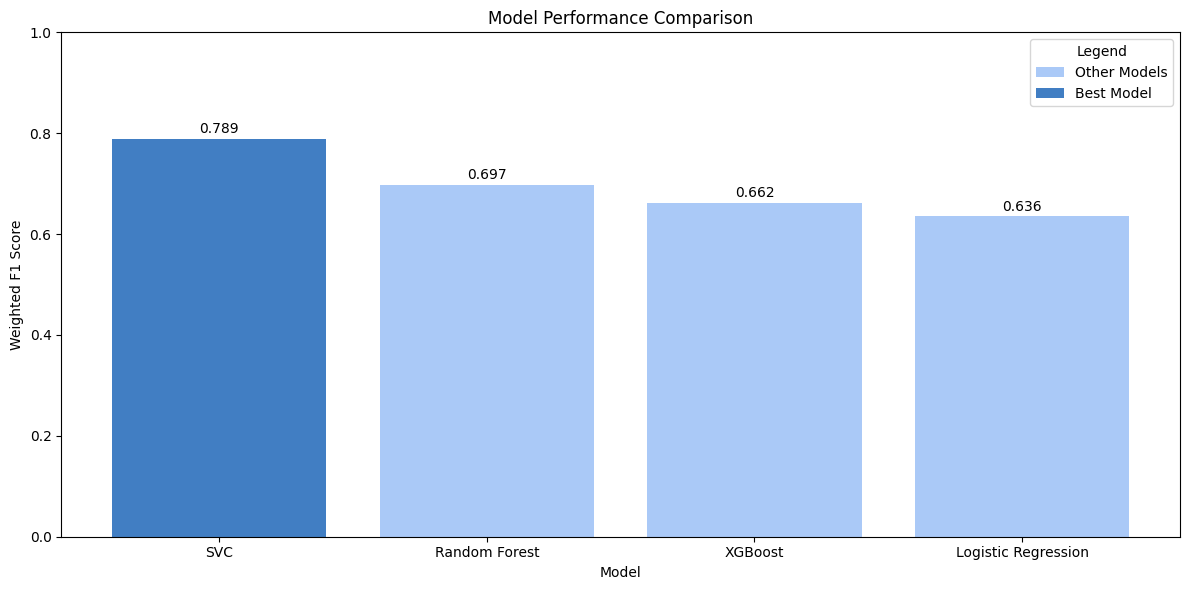

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sort by weighted_f1
results_df = pd.DataFrame(results_rows).sort_values("weighted_f1", ascending=False).reset_index(drop=True)

# Numeric x positions
x = np.arange(len(results_df))
scores = results_df["weighted_f1"].values
labels = results_df["model"].values

# find best model
best_idx = int(scores.argmax()) if hasattr(scores, "argmax") else int(np.argmax(scores))

# Colors
best_color = "#417ec3"
other_color = "#aac9f7"

plt.figure(figsize=(12, 6))

# Plot others
other_mask = np.ones(len(results_df), dtype=bool)
other_mask[best_idx] = False
plt.bar(x[other_mask], scores[other_mask], color=other_color, label="Other Models")

# Plot best
plt.bar(x[best_idx], scores[best_idx], color=best_color, label="Best Model")

# Annotations (now use numeric x positions)
for xi, val in zip(x, scores):
    plt.text(xi, val + 0.005, f"{val:.3f}", ha="center", va="bottom", fontsize=10)

# Axes/legend
plt.xticks(x, labels)
plt.legend(title="Legend")
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Weighted F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


#### Assess Support Vector Classification on Test Data

SVC (TEST) Macro F1: 0.7837
SVC (TEST) Weighted F1: 0.7952


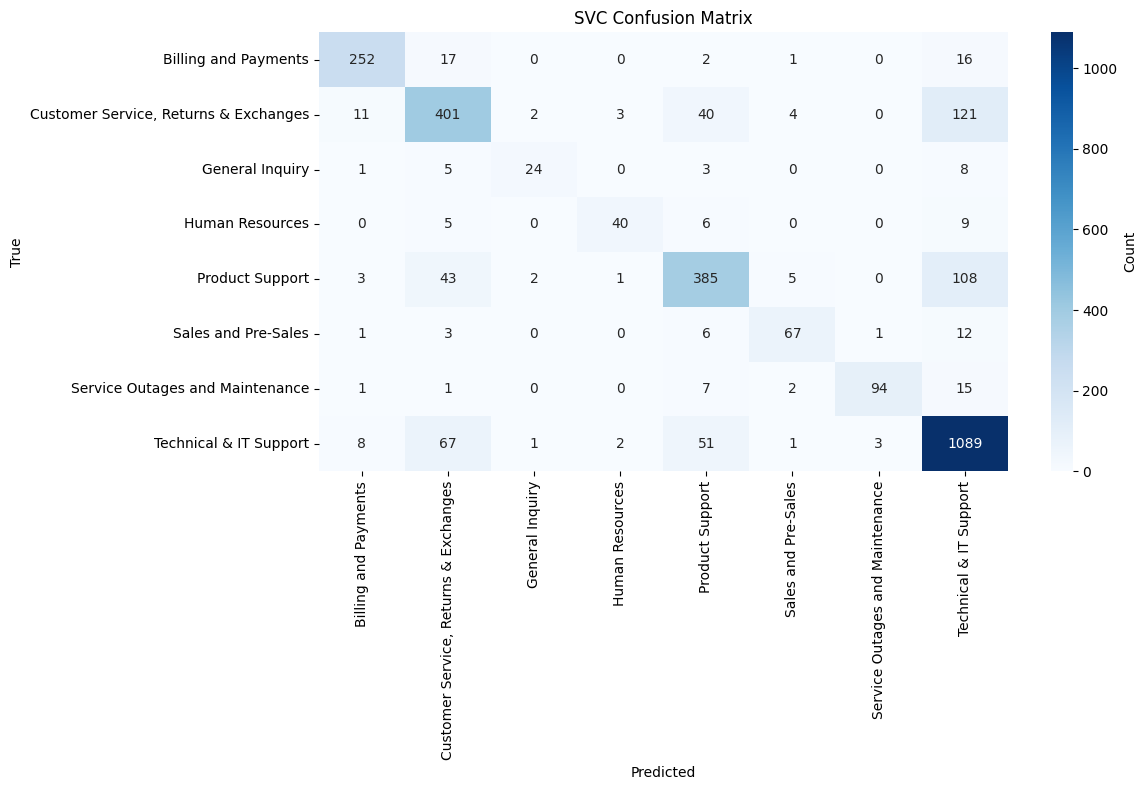

In [9]:
# declare svc_X and svc_y for Support Vector Classifier
svc_test_raw_y = test_data["queue_grouped"]
svc_test_enc_y = label_encoder.transform(svc_test_raw_y)

# use Sentence Transformer embeddings as features, then scale
svc_test_X = test_embeddings.astype(np.float32)
svc_test_X_scaled = scaler.transform(svc_test_X)

# make predictions
svc_test_preds = svm_model.predict(svc_test_X_scaled)

# evaluate model
svc_test_macro_f1 = f1_score(svc_test_enc_y, svc_test_preds, average="macro")
svc_test_weighted_f1 = f1_score(svc_test_enc_y, svc_test_preds, average="weighted")

print(f"SVC (TEST) Macro F1: {svc_test_macro_f1:.4f}")
print(f"SVC (TEST) Weighted F1: {svc_test_weighted_f1:.4f}")

# plot_confusion_heatmap
plot_confusion_heatmap(
    y_true=svc_test_enc_y,
    y_pred=svc_test_preds,
    class_names=label_encoder.classes_,
    title="SVC Confusion Matrix",
)

In [10]:
#save a table of predictions (decoded)
svc_test_pred_labels = label_encoder.inverse_transform(svc_test_preds)
svc_test_true_labels = label_encoder.inverse_transform(svc_test_enc_y)

test_out = test_data.copy()
test_out["true_label"] = svc_test_true_labels
test_out["pred_label"] = svc_test_pred_labels

cols_to_drop = ["combined_text", "queue_grouped", "redacted_text"]
test_out = test_out.drop(columns=cols_to_drop, errors="ignore")

#add a column for "correct" vs "misclassified"
test_out["is_correct"] = test_out["true_label"] == test_out["pred_label"]
test_out.head()

,redacted_text_clean,true_label,pred_label,is_correct
0,Significance of Implementing Advanced Security...,Technical & IT Support,Technical & IT Support,True
1,Assistance Needed for Security Breach A health...,Technical & IT Support,Technical & IT Support,True
2,Support for Security Gap Case An unauthorized ...,Product Support,Technical & IT Support,False
3,"Customer Support, I am seeking guidance on sec...","Customer Service, Returns & Exchanges","Customer Service, Returns & Exchanges",True
4,Issues with Marketing Tools Dear Customer Supp...,Technical & IT Support,Technical & IT Support,True


#### Interpretability
- https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=text#lime.lime_text.LimeTextExplainer
- https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=text#module-lime.explanation


In [11]:
#row to explain ~2-3mins to run
index_value = 1
row = test_data.loc[index_value]
text_instance = str(row["redacted_text_clean"])

#original classes from encoder
orig_class_names = list(label_encoder.classes_)

#Shorten names for presentation
short_map = {
    "Billing and Payments": "Bill & Payment",
    "Customer Service, Returns & Exchanges": "Cus. Serv & Ret",
    "General Inquiry": "Gen Inquiry",
    "Human Resources": "HR",
    "Product Support": "Prod Support",
    "Sales and Pre-Sales": "Sales & Pre‑Sales",
    "Service Outages and Maintenance": "Outages & Maint",
    "Technical & IT Support": "IT Support",
}
lime_class_names = [short_map.get(name, name) for name in orig_class_names]

#embed
embedder = SentenceTransformer("all-mpnet-base-v2")

# classifier fn for LIME (probabilities)
classifier_fn = lambda texts: svm_model.predict_proba(
    scaler.transform(
        embedder.encode(list(texts), show_progress_bar=False,
                        convert_to_numpy=True).astype(np.float32)
    )
)

# run Lime
explainer = LimeTextExplainer(class_names=lime_class_names, random_state=42)
exp = explainer.explain_instance(
    text_instance=text_instance,
    classifier_fn=classifier_fn,
    num_features=10,
    num_samples=3000,
    top_labels=1
)

#print true vs predicted label
proba_vec = classifier_fn([text_instance])[0]
pred_idx = int(np.argmax(proba_vec))
print(f"Predicted: {lime_class_names[pred_idx]} (p={proba_vec[pred_idx]:.3f})")

if "true_label" in test_out.columns:
    true_idx = orig_class_names.index(test_out.loc[index_value, "true_label"])
    print(f"True:      {lime_class_names[true_idx]}")

#show LIME results
HTML(exp.as_html(text=True, predict_proba=False))

Predicted: IT Support (p=0.892)
True:      IT Support


The plot above will not generate when viewed from the web, so we added the image below

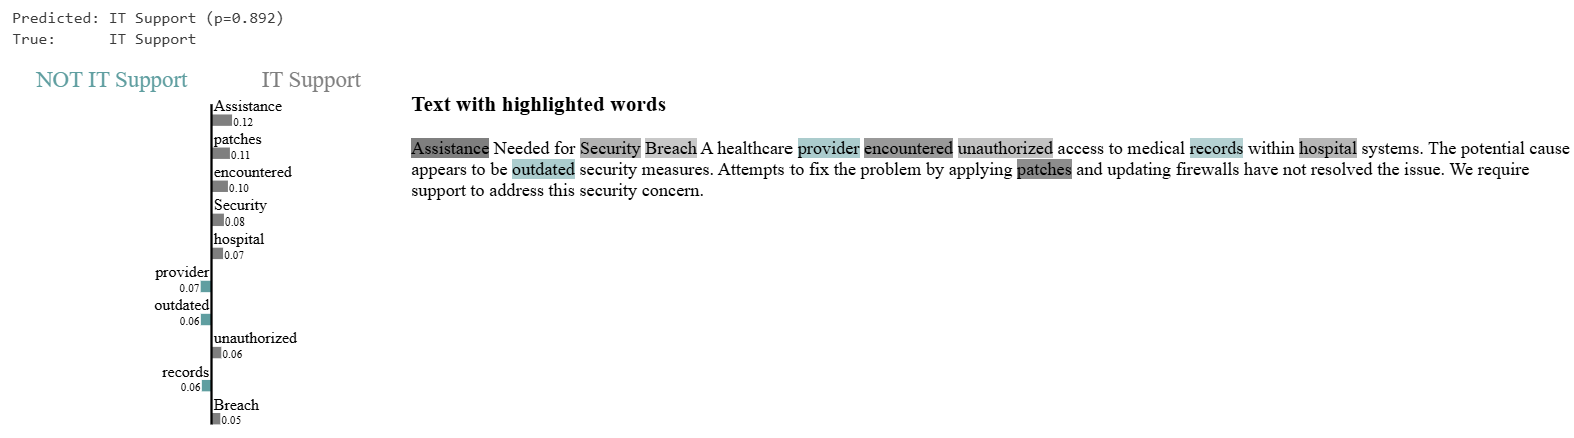